# 時系列分析(季節&トレンド)

## 方針

- レベル・トレンド・周期性の3要因に分けて、モデルを構築し、予測し、評価する。
- データを訓練データ、バリデーションデータ、テストデータの3つに分け、訓練データによって得られたモデルをバリデーションデータによって評価し、最適なモデルを選択する。テストデータは候補モデルの調査を一通り終えた後、最終評価にのみ使用する。
    - 分割の期間は各パーツ毎に適宜指定する。例えばかなり過去に販売されていたパーツなどは、直近のワランティ件数はほぼ0件であり、「2018年以降」などの一律な期間指定は評価に適さないため。
        - (余談)この方法は評価結果がデータの分割期間に依存する。より期間への依存が少ない方法としては、期間をスライドさせながら複数の評価を行い、その平均値や分布から評価する方法もある。しかしこの方法は、学習に計算時間がかかるモデルについては、計算時間の観点で現実的ではない。**粒子フィルタ(Particle Filter, SMC; Sequential Monte Carloとも)**などの比較的計算時間の少ないパラメータ推定方法では、このような評価方法も可能である。
    - 評価指標としては、バリデーションデータの平均二乗誤差(MSE; Mean Squared Error)を用いる。他、補助的に訓練データのBIC(ベイズ情報量基準)を用いることがある。
- スキルトランスファーの目的のため、以下の手法を用いてそれぞれモデリングを行う。**上2つはほぼ同じ結果となるため、実際では1つ採用すれば十分である。**
    - 1. SARIMA
        - 1.1 SARIMAX<font color=red>**(作業中)**</font>
    - 2. 状態空間モデル(線形-ガウス)
    - 3. 状態空間モデル(非線形-非ガウス)<font color=red>**(作業中)**</font>

## データ準備

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

PATH_DATA_INTERIM = Path("../data/interim/")

In [2]:
df_warranty_model_part_num_daily = pd.read_feather(PATH_DATA_INTERIM/"df_warranty_model_part_num_daily.feather")

/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [3]:
selected_part_TD = ["27610-76G", "37950-58J", "95411-82K", 
                    "09283-350", "33920-77F", "33220-76G", "55311-75F",
                    "55311-72J", "53200-58J", "84702-70K"]

selected_part_S = ["46860-76G", "95200-58J", "37990-72J", "09262-350",
                   "17400-588"]

In [4]:
ts_dict = {}
ts_dict_monthly = {}
for part in selected_part_TD:
    ts_tmp = (df_warranty_model_part_num_daily
              .loc[df_warranty_model_part_num_daily.part_cd == part,
                          ["date", "n"]]
              .groupby("date")["n"]
              .sum())
    ts_tmp.index = pd.to_datetime(ts_tmp.index)
    ts_dict[part] = ts_tmp
    ts_dict_monthly[part] = ts_tmp.resample("MS").sum()

In [5]:
ts_dict_S = {}
ts_dict_monthly_S = {}
for part in selected_part_S:
    ts_tmp = (df_warranty_model_part_num_daily
              .loc[df_warranty_model_part_num_daily.part_cd == part,
                          ["date", "n"]]
              .groupby("date")["n"]
              .sum())
    ts_tmp.index = pd.to_datetime(ts_tmp.index)
    ts_dict_S[part] = ts_tmp
    ts_dict_monthly_S[part] = ts_tmp.resample("MS").sum()

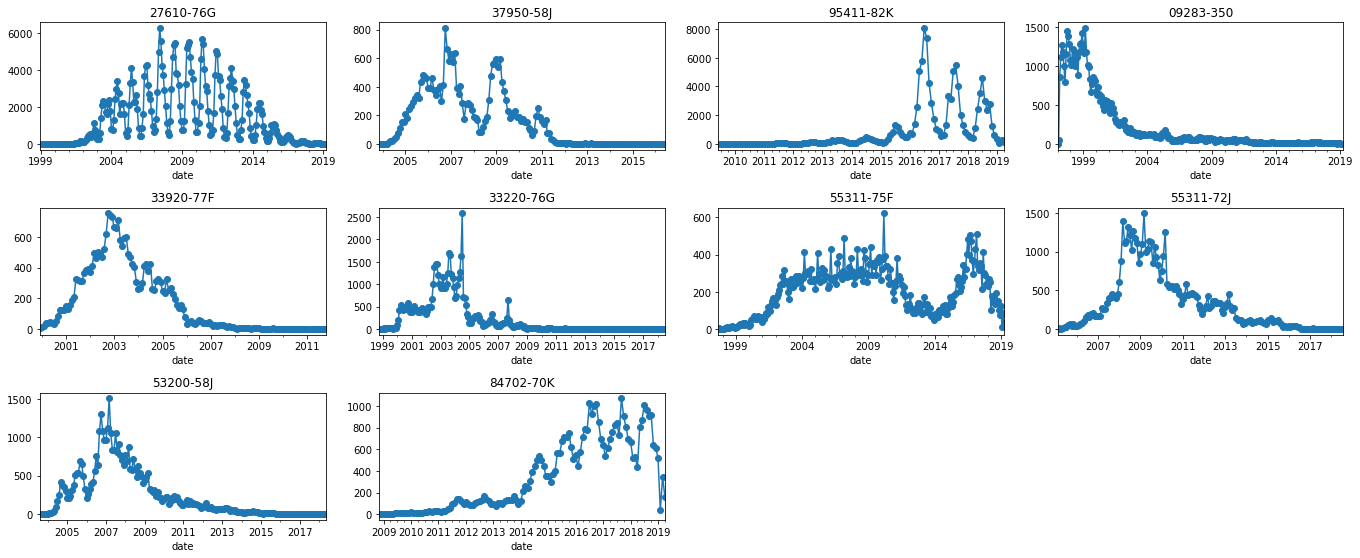

In [6]:
fig = plt.figure(figsize=(19,10))
for i, (part, ts) in enumerate(ts_dict_monthly.items()):
    ax = fig.add_subplot(4,4,i+1)
    ts.plot(style="-o", title=part, ax=ax)

plt.tight_layout()

In [7]:
df_term_devide = pd.DataFrame([{"part":"27610-76G", "valid_start":"2013-01-01", "test_start":"2014-01-01"},
                               {"part":"37950-58J", "valid_start":"2009-01-01", "test_start":"2010-01-01"},
                               {"part":"95411-82K", "valid_start":"2016-01-01", "test_start":"2017-01-01"},
                               {"part":"09283-350", "valid_start":"2000-01-01", "test_start":"2001-01-01"},
                               {"part":"33920-77F", "valid_start":"2003-01-01", "test_start":"2004-01-01"},
                               {"part":"33220-76G", "valid_start":"2003-01-01", "test_start":"2004-01-01"},
                               {"part":"55311-75F", "valid_start":"2016-01-01", "test_start":"2017-01-01"},
                               {"part":"55311-72J", "valid_start":"2011-01-01", "test_start":"2012-01-01"},
                               {"part":"53200-58J", "valid_start":"2008-01-01", "test_start":"2009-01-01"},
                               {"part":"84702-70K", "valid_start":"2016-01-01", "test_start":"2017-01-01"}])
df_term_devide.set_index("part", inplace=True)
df_term_devide["valid_start"] = pd.to_datetime(df_term_devide.valid_start)
df_term_devide["test_start"] = pd.to_datetime(df_term_devide.test_start)

In [8]:
from datetime import datetime, timedelta
datetime(2017,1,1) - timedelta(1)

datetime.datetime(2016, 12, 31, 0, 0)

In [9]:
from datetime import datetime, timedelta

ts_dict_monthly_train, ts_dict_monthly_valid, ts_dict_monthly_test = {},{},{}

for part in selected_part_TD:
    valid_start = df_term_devide.loc[part, "valid_start"]
    test_start = df_term_devide.loc[part, "test_start"]
    train_end = valid_start - timedelta(1)
    valid_end = test_start - timedelta(1)
    
    ts_dict_monthly_train[part] = ts_dict_monthly[part].loc[:train_end]
    ts_dict_monthly_valid[part] = ts_dict_monthly[part].loc[valid_start:valid_end]
    ts_dict_monthly_test[part] = ts_dict_monthly[part].loc[test_start:]

In [10]:
# スズキチームのパーツ(ts_dict_monthly_S)について時系列をプロットしてみましょう


In [11]:
# 各パーツについて、バリデーション期間開始日、テスト期間開始日を指定しましょう


In [12]:
# 各データを訓練、バリデーション、テストに分けましょう


## ベースラインモデル

これから作成するモデルの比較対象として、ベースラインとなるモデルを作成・評価する  
今回は**1.ランダムウォークモデル**と、2.稼働台数のx%が故障するモデルの2つをベースラインモデルとする。  
ベースラインとするモデルは、当然各ケースによって異なるが、ランダムウォークモデルはしばしば用いられる。

ランダムウォークモデルとは、以下のようなモデルである。
$$y_{t} = y_{t-1} + \epsilon_{t} \\
\epsilon_{t} \sim N(0, \sigma^2)$$
これは**係数1のAR1モデルと同一**である。
ランダムウォークモデルでは、次の値の期待値は現在の値となる。つまり、(正規分布にしたがうバラツキはもつものの)今とそれほど変わらない、という予測をするモデルである。  
ちなみに、株価や為替のモデルでは、このランダムウォークモデルがベースラインとなることが多い。(そして殆どの場合、ランダムウォークモデルよりも良い予測モデルは作れない...)

### ランダムウォークモデル

In [18]:
ts_monthly_train = ts_dict_monthly_train["27610-76G"]
ts_monthly_valid = ts_dict_monthly_valid["27610-76G"]
ts_monthly = ts_dict_monthly["27610-76G"]

In [19]:
from statsmodels.tsa.statespace.structural import UnobservedComponents

m_baseline = UnobservedComponents(ts_monthly_train, "random walk").fit()

In [20]:
m_baseline.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:                      n   No. Observations:                  169
Model:                    random walk   Log Likelihood               -1350.511
Date:                Thu, 18 Jul 2019   AIC                           2703.021
Time:                        03:47:29   BIC                           2706.145
Sample:                    12-01-1998   HQIC                          2704.289
                         - 12-01-2012                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
sigma2.level  5.642e+05   4.98e+04     11.324      0.000    4.67e+05    6.62e+05
===================================================================================
Ljung-Box (Q):                     1213.67   Jarque-Bera (JB):                26.31
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              23.03   Skew:                             0.81
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

BIC:2706.15


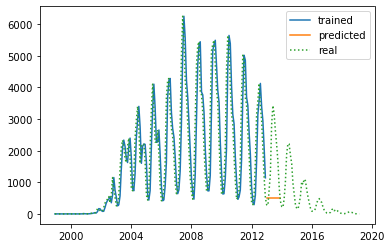

In [21]:
print(f"BIC:{m_baseline.bic:.2f}")
pred = m_baseline.predict()
forc = m_baseline.forecast(12)
ax = plt.subplot(1,1,1)
ax.plot(pred.index, pred.values, label="trained")
ax.plot(forc.index, forc.values, label="predicted")
ax.plot(ts_monthly.index, ts_monthly.values, ":", label="real")
ax.legend()

RMSE: 1592.27


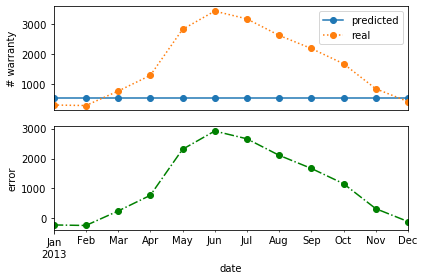

In [22]:
pred = m_baseline.forecast(12)
ax = plt.subplot(2,1,1)
pred.plot(ax=ax, style="o-", label="predicted")
ts_monthly_valid.plot(ax=ax, style="o:", label="real")
ax.set_ylabel("# warranty")
ax.legend()

ax.get_xaxis().set_visible(False)
ax = plt.subplot(2,1,2)
err = ts_monthly_valid - pred
err.plot(ax=ax, style="go-.", label="err")
ax.set_ylabel("error")
plt.tight_layout()
print(f"RMSE: {np.sqrt((err**2).mean()):.2f}")

月次の平均二乗誤差平方根はこのケースでは約1600件。

### 生産台数のX%モデル<font color=red>(作業中)</font>

## SARIMA

### SARIMAの概要

**SARIMA**はARIMAモデルを、季節変動要因が説明できるように改良したモデルである。ARIMAモデルと同様、非定常な過程についても(差分が定常であれば)使用できる。これと後述の**SARIMAX**を使用すれば、複雑なモデリングを除き、大概の時系列に適用できる。  
(複雑なモデリングについては、状態空間モデルを使用しなくてはならない)

SARIMAの考え方は、周期に対しても(ARIMAのように)差分を取って、ARMAで対応しようというアイデアである。  
例えば、月次のデータがあるとして、季節性を考慮したいとする。その場合、まず12で差分を取る(前年差を計算することになる)。
$$s_{t} = y_{t} - y_{t-12}$$
この前年差を、ARMAモデルで予測する。例えばARMA(1,1)モデルであれば
$$s_{t} = p_{0} + p_{1}s_{t-1} + q_{1}\epsilon_{t-1} + \epsilon_{t}$$
12月の前年差の期待値は、11月の前年差に$p_{1}$を掛けたものに、何かしら定数$p_{0}$を加えて(0とすることもある)、前月の予測結果との誤差に$q_{1}$を掛けたものを加えた値である、というようなモデルである。

また、非定常な時系列だと(月次売上推移など)、周期差分(前年差など)も非定常になることが多い。この場合、周期差分の差分(前年差の月次変化)を取ってから、ARMAにかける。例えば、周期12の差分を取った後に、更に1階差分を取る場合は
$$z_{t} = s_{t} - s_{t-1} = (y_{t} - y_{t-12}) - (y_{t-1} - y_{t-13}) = (y_{t} - y_{t-1}) - (y_{t-12} - y_{t-13}) = d_{t} - d_{t-12}$$

つまり、1階差を取ったあとに、周期12で差分を取る場合と等しい。  
この$sd_{t}$に対して、ARMAで予測を行っていく。例えばARMA(1,1)モデルであれば

$$z_{t} = p_{0} + p_{1}z_{t-1}+ q_{1}\epsilon_{t-1} + \epsilon_{t} = p_{0} + p_{1}\left\{(y_{t} - y_{t-12}) - (y_{t-1} - y_{t-13})\right\} + q_{1}\epsilon_{t-1} + \epsilon_{t}$$

SARIMAについては、AR1,2,3...やMA1,2,3...の他、周期でラグを取ることもある。例えば、通常のラグでAR1まで、周期ラグでAR2, MA1までモデリングする場合は、以下。

$$z_{t} = p_{0} + p_{1}z_{t-1} + p_{12}z_{t-12} + p_{24}z_{t-24} + q_{12}\epsilon_{t-12} + \epsilon_{t}$$

前年比の前月差$z_{t}$は、前月の値$z_{t-1}$の他、前年の値$z_{t-12}$や、前年の予測結果に対する誤差(上振れ/下振れ)$\epsilon_{t-12}$にも関係がある、というアイデアである。

### 実装

- ライブラリはstatsmodelsを使用する
- statsmodelsは最尤推定により、パラメータを推定している。
    - これはイメージとしては、学習に使用するデータが得られる確率が最も大きくなるようなパラメータを求める方法である。
    - 例えば、コイン投げの結果として、表が100回、裏が100回出たとする。このコインの表の出る確率をパラメータ$\theta$とする。このようなデータが得られる確率は、$\theta$が0.5のときに最大となる。(例えばコインが表が出やすくなっていて、$\theta=0.7$であった場合は、表100回、裏100回というデータはむしろ稀である)この場合に、「$\theta=0.5$である」と推定する方法が最尤推定である。

In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

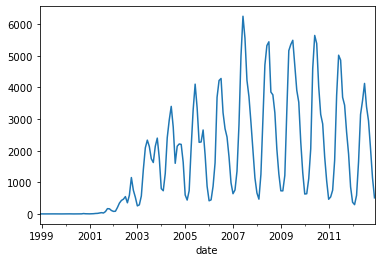

In [24]:
ts_monthly_train.plot()

#### そのままモデリング

In [25]:
from tqdm import tqdm_notebook

In [26]:
%%time

ar_param = [0,1,2,3,4]
ma_param = [0,1,2,3,4]
s_ar_param = [0,1,2]
s_ma_param = [0,1,2]

bic_list = {}

for p in tqdm_notebook(ar_param):
    for q in ma_param:
        for s_p in s_ar_param:
            for s_q in s_ma_param:
                try:
                    m = SARIMAX(ts_monthly_train, order=(p, 1, q), 
                               seasonal_order=(s_p, 1, s_q, 12)).fit()
                    bic_list[(p, q, s_p, s_q)] = m.bic
                except KeyboardInterrupt:
                    raise
                except:
                    pass

/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/statsmodels/base/model.py


CPU times: user 12min 7s, sys: 3.76 s, total: 12min 11s
Wall time: 3min 21s


/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [27]:
sorted(bic_list.items(), key=lambda x: x[1])[:5]

[((1, 1, 0, 0), 2287.1391411474583),
 ((1, 1, 0, 1), 2287.9908569398062),
 ((1, 1, 2, 0), 2288.8566021493575),
 ((1, 1, 1, 0), 2289.3386955784104),
 ((0, 0, 2, 0), 2290.0329300488183)]

In [28]:
m_sarima = SARIMAX(ts_monthly_train, order=(1,1,1), seasonal_order=(0,1,0,12)).fit()

上記のモデルは、前年差の月次変化に対して、AR1,MA1でモデリングしたもの。

In [29]:
m_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  n   No. Observations:                  169
Model:             SARIMAX(1, 1, 1)x(0, 1, 0, 12)   Log Likelihood               -1135.995
Date:                            Thu, 18 Jul 2019   AIC                           2277.990
Time:                                    03:50:53   BIC                           2287.139
Sample:                                12-01-1998   HQIC                          2281.706
                                     - 12-01-2012                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7238      0.073      9.881      0.000       0.580       0.867
ma.L1         -0.9500      0.038    -24.715      0.000      -1.025      -0.875
sigma2      1.232e+05   1.21e+04     10.193      0.000    9.95e+04    1.47e+05
===================================================================================
Ljung-Box (Q):                      105.94   Jarque-Bera (JB):                 5.15
Prob(Q):                              0.00   Prob(JB):                         0.08
Heteroskedasticity (H):               2.20   Skew:                            -0.04
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
# BICは以下のようにしても計算できる。
- 2 * m_sarima.llf + (m_sarima.df_model) * np.log(m_sarima.nobs_effective)

2287.1391411474583

BIC:2287.14


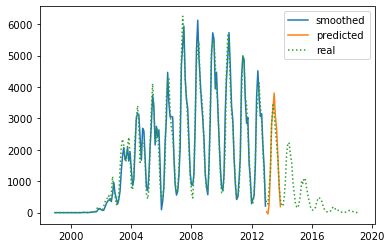

In [31]:
print(f"BIC:{m_sarima.bic:.2f}")
pred = m_sarima.predict()
ax = plt.subplot(1,1,1)
ax.plot(pred.index, pred.values, label="smoothed")
forc = m_sarima.forecast(12)
ax.plot(forc.index, forc.values, label="predicted")
ax.plot(ts_monthly.index, ts_monthly.values, ":", label="real")
ax.legend();

ベースラインモデルのBIC2700前後に比べて、2300前後と改善している。バリデーション期間も比較的良く予測できている。

In [32]:
m_sarima.forecast(steps=12)

2013-01-01      28.857926
2013-02-01     -40.454412
2013-03-01     257.662386
2013-04-01    1323.642173
2013-05-01    2819.798979
2013-06-01    3259.360101
2013-07-01    3804.490060
2013-08-01    3066.307938
2013-09-01    2620.899928
2013-10-01    1754.328417
2013-11-01     821.638563
2013-12-01     188.863050
Freq: MS, dtype: float64

マイナスの値を含んでしまっている。

RMSE: 328.50


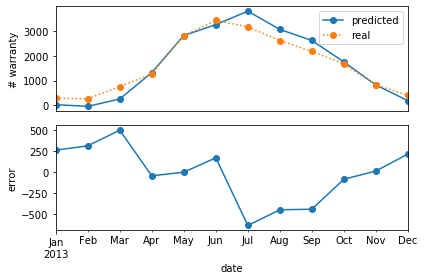

In [33]:
pred = m_sarima.forecast(12)
ax = plt.subplot(2,1,1)
pred.plot(ax=ax, style="o-", label="predicted")
ts_monthly_valid.plot(ax=ax, style="o:", label="real")
ax.set_ylabel("# warranty")
ax.legend()

ax.get_xaxis().set_visible(False)
ax = plt.subplot(2,1,2)
err = ts_monthly_valid - pred
err.plot(ax=ax, style="o-", label="err")
ax.set_ylabel("error")
plt.tight_layout()
print(f"RMSE: {np.sqrt((err**2).mean()):.2f}")

月次の平均二乗誤差平方根はこのケースでは330件。

#### 対数変換を施してからモデリング

In [34]:
m_sarima_l1p = SARIMAX(np.log1p(ts_monthly_train), order=(1,1,1), seasonal_order=(0,1,0,12)).fit()

In [35]:
m_sarima_l1p.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  n   No. Observations:                  169
Model:             SARIMAX(1, 1, 1)x(0, 1, 0, 12)   Log Likelihood                 -67.247
Date:                            Thu, 18 Jul 2019   AIC                            140.493
Time:                                    03:50:54   BIC                            149.643
Sample:                                12-01-1998   HQIC                           144.210
                                     - 12-01-2012                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1746      0.115     -1.520      0.128      -0.400       0.050
ma.L1         -0.2897      0.112     -2.593      0.010      -0.509      -0.071
sigma2         0.1385      0.010     13.882      0.000       0.119       0.158
===================================================================================
Ljung-Box (Q):                       54.95   Jarque-Bera (JB):               137.73
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               0.08   Skew:                             1.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

BIC:149.64


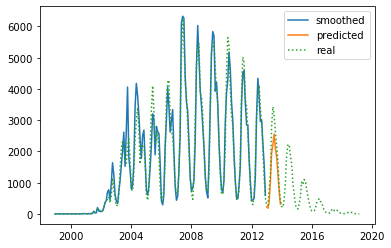

In [36]:
print(f"BIC:{m_sarima_l1p.bic:.2f}")
pred = np.expm1(m_sarima_l1p.predict())
ax = plt.subplot(1,1,1)
ax.plot(pred.index, pred.values, label="smoothed")
forc = np.expm1(m_sarima_l1p.forecast(12))
ax.plot(forc.index, forc.values, label="predicted")
ax.plot(ts_monthly.index, ts_monthly.values, ":", label="real")
ax.legend();

**眞田宿題**: BIC精査

BICは大幅に改善するが、バリデーション期間の予測精度は下がってしまった。

MSE: 532.63


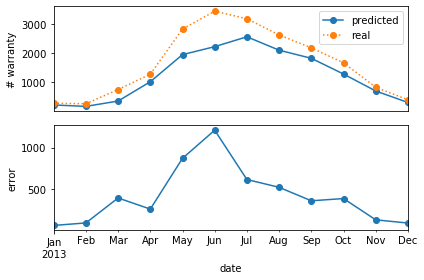

In [37]:
pred = np.expm1(m_sarima_l1p.forecast(12))
ax = plt.subplot(2,1,1)
pred.plot(ax=ax, style="o-", label="predicted")
ts_monthly_valid.plot(ax=ax, style="o:", label="real")
ax.set_ylabel("# warranty")
ax.legend()

ax.get_xaxis().set_visible(False)
ax = plt.subplot(2,1,2)
err = ts_monthly_valid - pred
err.plot(ax=ax, style="o-", label="err")
ax.set_ylabel("error")
plt.tight_layout()
print(f"MSE: {np.sqrt((err**2).mean()):.2f}")

月次の平均二乗誤差平方根はこのケースでは330件。

### (Optional)SARIMAXモデル<font color=red>(作業中)</font>

- SARIMAXはSARIMAモデルを、外生変数の影響も組み込めるように改良したモデルである。

## 状態空間モデル(線形-ガウス)

- ライブラリはstatsmodelsを使用する。
- 以下のような状態空間モデルを仮定し、パラメータと状態$s_{t}$を推定する。
- ...

In [38]:
m_dlm = UnobservedComponents(ts_monthly_train, 'local linear trend', 
                             freq_seasonal=[{"period":12}]).fit()

In [39]:
m_dlm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                Unobserved Components Results                                
=============================================================================================
Dep. Variable:                                     n   No. Observations:                  169
Model:                            local linear trend   Log Likelihood               -1157.095
                   + stochastic freq_seasonal(12(6))   AIC                           2322.190
Date:                               Thu, 18 Jul 2019   BIC                           2334.363
Time:                                       03:50:55   HQIC                          2327.134
Sample:                                   12-01-1998                                         
                                        - 12-01-2012                                         
Covariance Type:                                 opg                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
sigma2.irregular               0.0005   1.14e+04   3.95e-08      1.000   -2.24e+04    2.24e+04
sigma2.level                1.188e+04   4803.876      2.473      0.013    2462.942    2.13e+04
sigma2.trend                  27.3543     36.392      0.752      0.452     -43.972      98.681
sigma2.freq_seasonal_12(6)  1514.4694    271.339      5.581      0.000     982.654    2046.285
===================================================================================
Ljung-Box (Q):                      248.58   Jarque-Bera (JB):                 9.42
Prob(Q):                              0.00   Prob(JB):                         0.01
Heteroskedasticity (H):               1.31   Skew:                             0.15
Prob(H) (two-sided):                  0.34   Kurtosis:                         4.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

BIC:2334.36


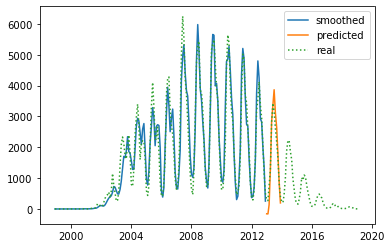

In [41]:
print(f"BIC:{m_dlm.bic:.2f}")
pred = m_dlm.predict()
ax = plt.subplot(1,1,1)
ax.plot(pred.index, pred.values, label="smoothed")
forc = m_dlm.forecast(12)
ax.plot(forc.index, forc.values, label="predicted")
ax.plot(ts_monthly.index, ts_monthly.values, ":", label="real")
ax.legend()

RMSE: 383.90


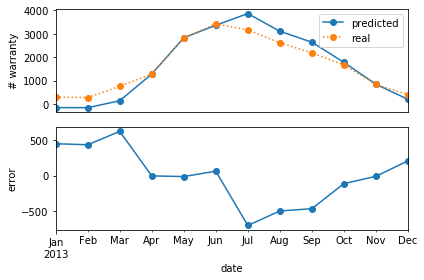

In [42]:
pred = m_dlm.forecast(12)
ax = plt.subplot(2,1,1)
pred.plot(ax=ax, style="o-", label="predicted")
ts_monthly_valid.plot(ax=ax, style="o:", label="real")
ax.set_ylabel("# warranty")
ax.legend()

ax.get_xaxis().set_visible(False)
ax = plt.subplot(2,1,2)
err = ts_monthly_valid - pred
err.plot(ax=ax, style="o-", label="err")
ax.set_ylabel("error")
plt.tight_layout()
print(f"RMSE: {np.sqrt((err**2).mean()):.2f}")

In [43]:
m_dlm_l1p = UnobservedComponents(np.log1p(ts_monthly_train), 'local linear trend', 
                                 freq_seasonal=[{"period":12}]).fit()
m_dlm_l1p.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                Unobserved Components Results                                
=============================================================================================
Dep. Variable:                                     n   No. Observations:                  169
Model:                            local linear trend   Log Likelihood                 -61.856
                   + stochastic freq_seasonal(12(6))   AIC                            131.713
Date:                               Thu, 18 Jul 2019   BIC                            143.887
Time:                                       03:54:09   HQIC                           136.658
Sample:                                   12-01-1998                                         
                                        - 12-01-2012                                         
Covariance Type:                                 opg                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
sigma2.irregular               0.0246      0.007      3.561      0.000       0.011       0.038
sigma2.level                   0.0009      0.006      0.148      0.882      -0.011       0.012
sigma2.trend                   0.0006      0.000      2.192      0.028    6.27e-05       0.001
sigma2.freq_seasonal_12(6)     0.0005      0.000      2.998      0.003       0.000       0.001
===================================================================================
Ljung-Box (Q):                       65.49   Jarque-Bera (JB):                51.22
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.09   Skew:                             0.82
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

BIC:143.89


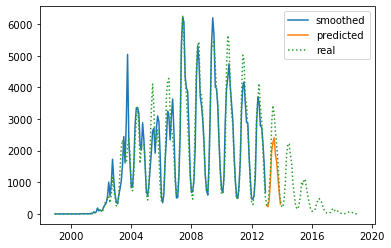

In [44]:
print(f"BIC:{m_dlm_l1p.bic:.2f}")
pred = np.expm1(m_dlm_l1p.predict())
ax = plt.subplot(1,1,1)
ax.plot(pred.index, pred.values, label="smoothed")
forc = np.expm1(m_dlm_l1p.forecast(12))
ax.plot(forc.index, forc.values, label="predicted")
ax.plot(ts_monthly.index, ts_monthly.values, ":", label="real")
ax.legend()

MSE: 577.75


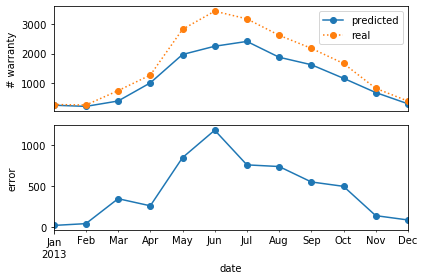

In [45]:
pred = np.expm1(m_dlm_l1p.forecast(12))
ax = plt.subplot(2,1,1)
pred.plot(ax=ax, style="o-", label="predicted")
ts_monthly_valid.plot(ax=ax, style="o:", label="real")
ax.set_ylabel("# warranty")
ax.legend()

ax.get_xaxis().set_visible(False)
ax = plt.subplot(2,1,2)
err = ts_monthly_valid - pred
err.plot(ax=ax, style="o-", label="err")
ax.set_ylabel("error")
plt.tight_layout()
print(f"MSE: {np.sqrt((err**2).mean()):.2f}")

## 状態空間モデル(非線形-非ガウス)<font color=red>(作業中)</font>

- ライブラリはPyStanを使用する
- 以下のような状態空間モデルを仮定し、パラメータと状態$s_{t}$を推定する。
- 上記のようなモデルは、非線形-非ガウスに分類される。このようなモデルのパラメータと状態$s_{t}$を推定する方法は、例えば以下の2つの方法がある。
    - 粒子フィルタ(逐次モンテカルロ法, SMCとも呼ぶ)
    - MCMC(マルコフ連鎖モンテカルロ法)
- 今回は、MCMCによって推定を行う。

In [ ]:
import pystan

In [ ]:
model = """data {
  int<lower=1> n;
  int<lower=1> m;
  int y[n];  
}
parameters {
  vector[n] mu;
  vector[n] trend;
  vector[n] seasonal;
  real<lower=0> sigma_level;
  real<lower=0> sigma_trend;
  real<lower=0> sigma_seas;
  real<lower=0> sigma_irreg;
}
transformed parameters {
  vector[n] yhat;
  yhat = mu + seasonal;
}
model {
  for(t in 12:n)
    seasonal[t] ~ normal(- sum(seasonal[t-11:t-1]), sigma_seas);

  for(t in 2:n)
  {
    mu[t] ~ normal(mu[t-1] + trend[t-1], sigma_level);
    trend[t] ~ normal(trend[t-1], sigma_trend);
  }
  
  y ~ poisson(yhat);
}

generated quantities {
    vector[n + m] seasonal_pred;
    vector[n + m] mu_pred;
    vector[n + m] trend_pred;
    int y_pred[n + m];
    seasonal_pred[1:n] = seasonal;
    mu_pred[1:n] = mu;
    trend_pred[1:n] = trend;
    y_pred[1:n] = y;

    for (t in 1:m) {
        seasonal_pred[n+t] = normal_rng(- sum(seasonal_pred[(n+t-11):(n+t-1)]), sigma_seas);
        mu_pred[n+t] = normal_rng(mu_pred[n+t-1], sigma_level);
        trend_pred[n+t] = normal_rng(trend_pred[n+t-1], sigma_trend);
        
        y_pred[n+t] = poisson_rng(mu_pred[n+t] + seasonal_pred[n+t] + trend_pred[n+t]);
    }
    
}
"""

In [ ]:
dat = {"y": ts_monthly_train.values,
      "n": len(ts_monthly),
      "m":12}

sm = pystan.StanModel(model_code=model)
fit = sm.sampling(data=dat, iter=1000, chains=4)

In [ ]:
la = fit.extract(permuted=True, inc_warmup=False)  # return a dictionary of arrays

level = la["mu"].mean(axis=0)
cycle = la["seasonal"].mean(axis=0)
trend = la["trend"].mean(axis=0)
yhat = la["yhat"].mean(axis=0)

plt.plot(level, "--",label="level")
plt.plot(cycle, "-.", label="cycle")
plt.plot(trend, ":", label="trend")
plt.plot(yhat, "-", label="trend")
plt.plot(np.log1p(ts_momthly.values), "b-", alpha=0.5, label="real")
plt.legend()

In [ ]:
model_2 = """data {
  int<lower=1> n;
  int<lower=1> m;
  int y[n];  
}
parameters {
  vector[n] mu;
  vector[n] trend;
  vector[n] seasonal;
  real<lower=0> sigma_level;
  real<lower=0> sigma_trend;
  real<lower=0> sigma_seas;
  real<lower=0> sigma_irreg;
}
transformed parameters {
  vector[n] yhat;
  yhat = mu + seasonal;
}
model {
  for(t in 12:n)
    seasonal[t] ~ normal(- sum(seasonal[t-11:t-1]), sigma_seas);

  for(t in 2:n)
  {
    mu[t] ~ normal(mu[t-1] + trend[t-1], sigma_level);
    trend[t] ~ normal(trend[t-1], sigma_trend);
  }
  
  y ~ poisson(yhat);
}

generated quantities {
    vector[n + m] seasonal_pred;
    vector[n + m] mu_pred;
    vector[n + m] trend_pred;
    int y_pred[n + m];
    seasonal_pred[1:n] = seasonal;
    mu_pred[1:n] = mu;
    trend_pred[1:n] = trend;
    y_pred[1:n] = y;

    for (t in 1:m) {
        seasonal_pred[n+t] = normal_rng(- sum(seasonal_pred[(n+t-11):(n+t-1)]), sigma_seas);
        mu_pred[n+t] = normal_rng(mu_pred[n+t-1], sigma_level);
        trend_pred[n+t] = normal_rng(trend_pred[n+t-1], sigma_trend);
        
        y_pred[n+t] = poisson_rng(mu_pred[n+t] + seasonal_pred[n+t] + trend_pred[n+t]);
    }
    
}
"""

In [ ]:
dat = {"y": ts_monthly.values,
      "n": len(ts_monthly)}

sm = pystan.StanModel(model_code=model)
fit = sm.sampling(data=dat, iter=1000, chains=4)

In [ ]:
la = fit.extract(permuted=True, inc_warmup=False)  # return a dictionary of arrays

level = la["mu"].mean(axis=0)
cycle = la["seasonal"].mean(axis=0)
trend = la["trend"].mean(axis=0)
yhat = la["yhat"].mean(axis=0)

plt.plot(level, "--",label="level")
plt.plot(cycle, "-.", label="cycle")
plt.plot(trend, ":", label="trend")
plt.plot(yhat, "-", label="trend")
plt.plot(ts_momthly.values, "b-", alpha=0.5, label="real")
plt.legend()